##基礎演習S 後半第4回

NE21-1228F
鈴木　拓己

In [ ]:
# 参考：インストール済みパッケージ
p <- installed.packages()
rownames(p)

In [ ]:
# 必要に応じて「ランタイム」＋「ランタイムを再起動」
# IPAフォントをインストール
system("apt-get install -y fonts-ipafont")
# フォント一覧を表示
# systemfonts::system_fonts()
# グラフィクスパラメータのフォントファミリーをIPAGothicに
par(family="IPAGothic")
# 確認（グラフでの日本語）
dat <- cars
head(dat, 3)
colnames(dat) <- c("速度","距離")
plot(dat)

In [ ]:
# ライブラリ
library(tidyverse)

### Ex.4-3 carsデータで多項式モデリング（正則化・交差検証）

In [ ]:
# 関数定義（Ex.4-1～4-3用）
RMSE <- function(f, y) sqrt(mean((f-y)^2))
MAE <- function(f, y) mean(abs(f-y))
#---
g <- function(x, a){        # n次多項式によるモデル，aの要素は昇べき順
  n <- length(a)
  z <- a[n]
  if(n > 1){
    for(i in (n-1):1){        # 計算は降べき順
      z <- z*x + a[i]
    }
  }
  return(z)
}

In [ ]:
# データ定義（Ex.4-1～4-3用）
X <- x0 <- data.frame(cars$speed)
for(i in 2:10) X <- cbind(X, X[,i-1]*x0)
colnames(X) <- paste0('x', 1:10)
# distを目的変数yとする
y <- cars$dist
# dはyとXをまとめたもの
d <- data.frame(y, X)
#---------------------------------------
# [1]
#（ランダムに）Xの70%を訓練データX1，残り30%をテストデータX2とする
set.seed(123)          # 乱数種設定　※再現性のため
n <- nrow(X); r <- 0.7
id <- sample(1:n, round(n*r)) %>% sort()

X1 <- X[id, ]
X2 <- X[-id, ]
d1 <- d[id,]
d2 <- d[-id,]

#変数idに1からn(Xの行数)の数を0.7✖️n回(四捨五入)サンプリング(seed値を設定しているため一定になる)を行い、昇順に並び替える。
#X1にはXのidに対応する行を代入し、X2にはXのidに対応しない行を代入する。
#d1にはdのidに対応する行を代入し、d2にはdのidに対応しない行を代入する。

In [ ]:
dat <- data.frame(cars$speed,cars$dist)
dat1 <-dat[id,];colnames(dat1)[1] <- 'x';colnames(dat1)[2] <- 'y'
dat2 <-dat[-id,];colnames(dat2)[1] <- 'x';colnames(dat2)[2] <- 'y'

In [ ]:
# Lasso回帰（glmnetのα=1）　※ハイパーパラメータの学習なし（λ=1に固定）
# データは例題4-2と同様（X1, X2は10次の冪まで）
#---
# [1] glmnet関数でモデル作成，モデルパラメータ（係数）を求める
install.packages('glmnet')
library(glmnet)
y1 <- y[id]
model5 <- glmnet(X1, y1, family = "gaussian", lambda = 1, alpha = 1)

a5 <- c(model5$a0, as.numeric(model5$beta))   # 係数
a5
a5 <- a5[1:2]

# 8次多項式が推定されている y = 4.65 + 1.80x + 2.19731101657613e-06*x^6 + 7.04539229719057e-08*x^7 + 1.37801229099714e-09*x^8
#x^6,x^7,x^8の係数を0と仮定すると1次多項式になり
 #y = 4.65 + 1.80x

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



s0                                                                  
4.654345e+00 1.795484e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.197311e-06 
                                                                 
7.045392e-08 1.378012e-09 0.000000e+00 0.000000e+00 0.000000e+00

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


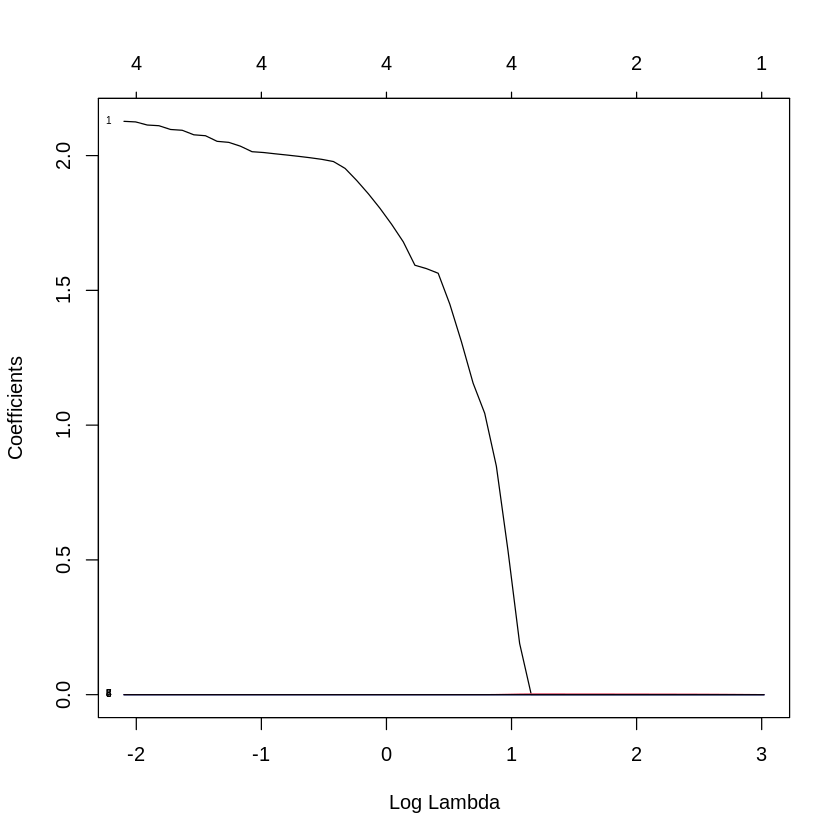

[1] 3.493405

[1] 8.857054

11 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) 2.154000e+01
x1          .           
x2          .           
x3          3.085977e-03
x4          4.477502e-05
x5          9.652720e-11
x6          .           
x7          .           
x8          .           
x9          .           
x10         .           

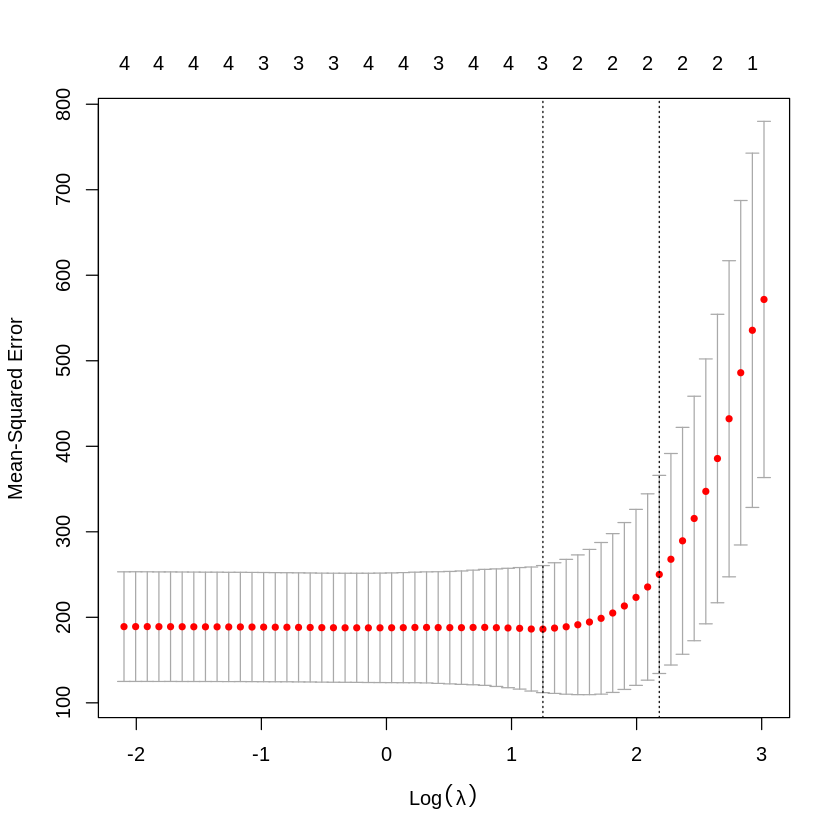

In [ ]:
# [2] Lasso回帰　※ハイパーパラメータλの学習あり
# glmnet関数

model6 <- glmnet(X1, y1, family="gaussian", alpha=1, maxit=10^6)

# 解パス

plot(model6, xvar="lambda", label=TRUE)

# 一つ抜き交差検証

model6_cv <- cv.glmnet(x=as.matrix(X1), y=y1, family="gaussian", alpha=1,maxit=10^6, nfolds=length(y1))

# λと2乗平均誤差の関係

plot(model6_cv)

# 最適なλは6.175

model6_cv$lambda.min
model6_cv$lambda.1se

# モデルパラメータ（係数）

a6 <- coef(model6_cv, s = "lambda.min")
a6
a6 <- a6[1]

Warning message:
“Removed 1 rows containing missing values (geom_point).”


[1] 18.52354

[1] 12.20714

[1] 29.93229

[1] 21.21886

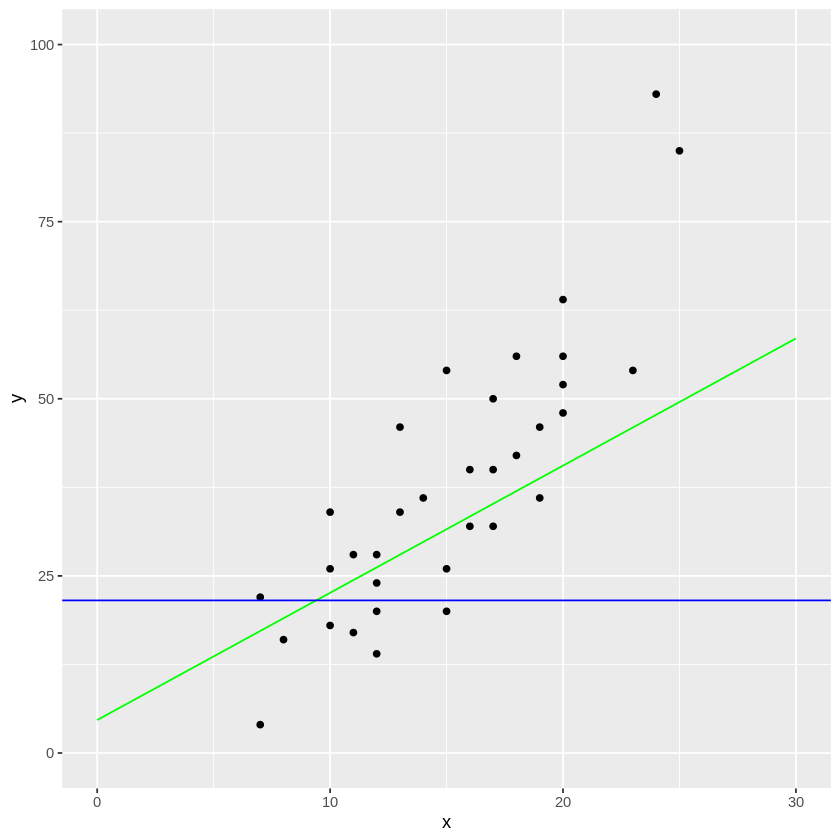

[1] 27.44486

[1] 21.79317

[1] 40.13701

[1] 33.20933

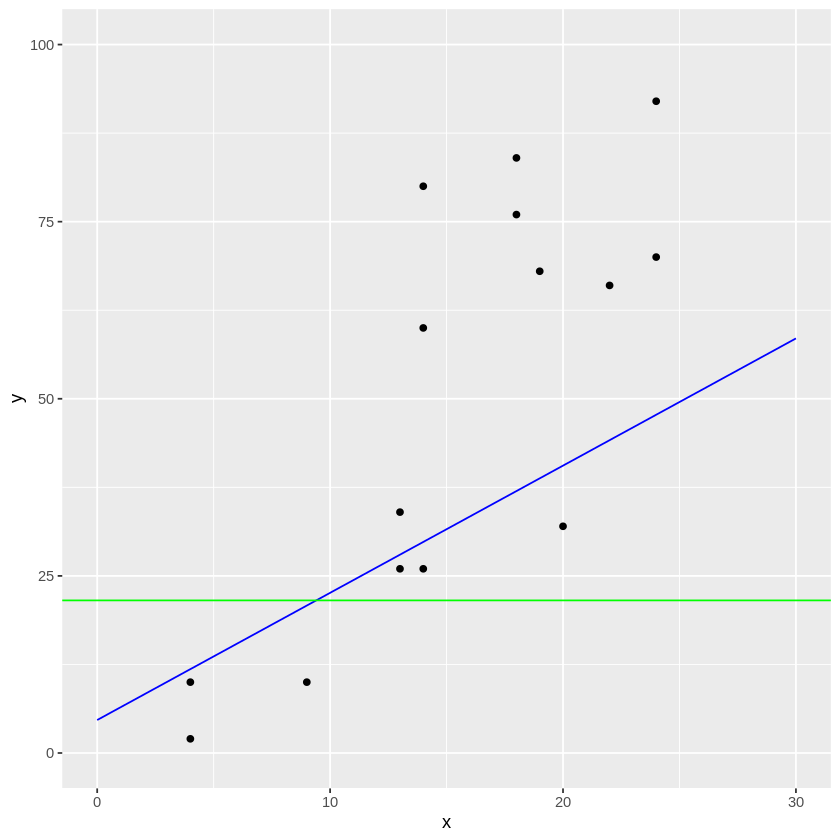

In [ ]:
# [3] 視覚化（訓練データの散布図とモデル）
# グラフ（モデルの当てはまり）

ggplot(dat1, aes(x=x, y=y)) + geom_point() + 
    stat_function(fun=g, args=list(a=a5), color="green") +
    geom_hline(yintercept=a6, color="blue") +
    xlim(c(0, 30)) + ylim(c(0, 100))

# 残差（訓練データ）※学習なし

RMSE(g(dat1$x, a5), dat1$y)
MAE(g(dat1$x, a5), dat1$y)

# 残差（訓練データ）※学習あり

RMSE(g(dat1$x, a6), dat1$y)
MAE(g(dat1$x, a6), dat1$y)

# テストデータで検証
# 視覚化（テストデータの散布図とモデル）

ggplot(dat2, aes(x=x, y=y)) + geom_point() + 
    stat_function(fun=g, args=list(a=a5), color="blue") +
    geom_hline(yintercept=a6, color="green") +
    xlim(c(0, 30)) + ylim(c(0, 100))

# 残差（テストデータ））※学習なし

RMSE(g(dat2$x, a5), dat2$y)
MAE(g(dat2$x, a5), dat2$y)

# 残差（テストデータ））※学習あり

RMSE(g(dat2$x, a6), dat2$y)
MAE(g(dat2$x, a6), dat2$y)